initial code
```{python}
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1hJGgFSvtRsNREGPVjkSTLZqOzNc0okgv/view?usp=sharing'
id = link.split('/')[-2]
print(id)

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Enable mixed precision for A100 optimization
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

path = "/content/drive/MyDrive/all_train.csv"

import tensorflow as tf
import numpy as np

data_file = path
temp_data_set = tf.data.experimental.make_csv_dataset(
    data_file,
    batch_size=1000,
    num_epochs=1,
    label_name='# label',
    ignore_errors=True,
)

def pack(features, label):
    return tf.stack(list(features.values()), axis=-1), tf.cast(label, tf.int32)

packed_dataset = temp_data_set.map(pack)

for features, labels in packed_dataset.take(1):
    print(features.shape)
    print(np.unique(labels.numpy()))
    print(len(features.numpy()))
    print(labels.numpy())

from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

my_model = Sequential()
my_model.add(tf.keras.Input(shape=(28,)))
my_model.add(BatchNormalization())
my_model.add(Dense(500, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dense(400, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dense(300, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dense(200, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dense(100, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dense(1, activation='sigmoid', dtype='float32'))  # output must be float32

train_size = int(0.8 * 1000)
val_size = int(0.2 * 1000)

full_dataset = packed_dataset.shuffle(buffer_size=1000)
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(val_size)

from tensorflow.keras.optimizers import Adam
opt = Adam()

my_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[
    'accuracy',
    tf.keras.metrics.FalseNegatives(name='false_negatives_1'),
    tf.keras.metrics.FalsePositives(name='false_positives_1'),
    tf.keras.metrics.AUC(name='auc_1'),
    tf.keras.metrics.Precision(name='precision_1'),
    tf.keras.metrics.Recall(name='recall_1')
])

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)

%load_ext tensorboard
%tensorboard --logdir logs

safety = EarlyStopping(patience=3, monitor='val_loss')

history = my_model.fit(
    packed_dataset.take(train_size),
    validation_data=packed_dataset.skip(train_size),
    epochs=1000,
    callbacks=[safety, tb]
)

print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
```

In [ ]:
# mount
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install pydrive2
!pip install -U -q PyDrive2


In [ ]:
# Authenticate PyDrive2
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [ ]:
# Enable Mixed Precision (for A100 GPU)
import tensorflow as tf

data_file = "/content/drive/MyDrive/all_train.csv.gz"

temp_data_set = tf.data.experimental.make_csv_dataset(
    data_file,
    compression_type='GZIP',
    batch_size=1000,
    num_epochs=1,
    label_name='# label',
    ignore_errors=True,
)


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [ ]:
#load and Stream the GZIP Dataset from Drive
import tensorflow as tf

data_file = "/content/drive/MyDrive/all_train.csv.gz"

temp_data_set = tf.data.experimental.make_csv_dataset(
    data_file,
    compression_type='GZIP',
    batch_size=1000,
    num_epochs=1,
    label_name='# label',
    ignore_errors=True,
)


In [ ]:
#  Pack Features into Tensor Format
def pack(features, label):
    return tf.stack(list(features.values()), axis=-1), tf.cast(label, tf.int32)

packed_dataset = temp_data_set.map(pack)


In [ ]:
# Preview the Dataset (Optional Sanity Check)
for features, labels in packed_dataset.take(1):
    print(features.shape)  # should be (1000, 28)
    print(tf.reduce_min(labels), tf.reduce_max(labels))  # should be 0 and 1


(1000, 28)
tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
train_size = 800
val_size = 200

full_dataset = packed_dataset.shuffle(buffer_size=1000)
train_dataset = full_dataset.take(train_size).repeat()
val_dataset = full_dataset.skip(train_size).repeat()


In [ ]:
# Build the Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

model = Sequential([
    tf.keras.Input(shape=(28,)),
    BatchNormalization(),
    Dense(500, activation='relu'),
    BatchNormalization(),
    Dense(400, activation='relu'),
    BatchNormalization(),
    Dense(300, activation='relu'),
    BatchNormalization(),
    Dense(200, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid', dtype='float32')  # force final output to float32
])



In [ ]:
# compile
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        'accuracy',
        tf.keras.metrics.FalseNegatives(name='false_negatives_1'),
        tf.keras.metrics.FalsePositives(name='false_positives_1'),
        tf.keras.metrics.AUC(name='auc_1'),
        tf.keras.metrics.Precision(name='precision_1'),
        tf.keras.metrics.Recall(name='recall_1')
    ]
)


In [ ]:
# Set Up TensorBoard Logging and Early Stopping
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
safety = EarlyStopping(patience=3, monitor='val_loss')


In [ ]:
# # train the model
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     steps_per_epoch=800,
#     validation_steps=200,
#     epochs=1000,
#     callbacks=[safety, tb]
# )


In [ ]:
# # faster - train the model

# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     steps_per_epoch=800,
#     validation_steps=200,
#     epochs=1000,
#     callbacks=[safety, tb],
#     verbose=0  # fastest screen-wise
# )


In [ ]:
# use cv not tts:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np

# Load full dataset once
df = pd.read_csv("/content/drive/MyDrive/all_train.csv.gz", compression='gzip')
# X = df.drop(columns=['# label', 'mass']).values #(comment out for use w cv - use for tts)

X = df.drop(columns=['# label']).values #(use with CV comment out for tts)

y = df['# label'].values

# K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nFOLD {fold + 1}")
    x_train, x_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build a new model for each fold
    model = Sequential([
        tf.keras.Input(shape=(28,)),
        BatchNormalization(),
        Dense(500, activation='relu'),
        BatchNormalization(),
        Dense(400, activation='relu'),
        BatchNormalization(),
        Dense(300, activation='relu'),
        BatchNormalization(),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid', dtype='float32'),
    ])

    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    model.fit(x_train, y_train, epochs=3, batch_size=1000, verbose=0)

    # Evaluate
    y_pred = model.predict(x_val) > 0.5
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    all_metrics.append((acc, prec, rec, auc))
    print(f"ACC: {acc:.4f}  PREC: {prec:.4f}  REC: {rec:.4f}  AUC: {auc:.4f}")



FOLD 1
43750/43750 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step
ACC: 0.8841  PREC: 0.8737  REC: 0.8980  AUC: 0.8841

FOLD 2
43750/43750 ━━━━━━━━━━━━━━━━━━━━ 58s 1ms/step
ACC: 0.8835  PREC: 0.8615  REC: 0.9140  AUC: 0.8835

FOLD 3
43750/43750 ━━━━━━━━━━━━━━━━━━━━ 57s 1ms/step
ACC: 0.8836  PREC: 0.8762  REC: 0.8935  AUC: 0.8836

FOLD 4
43750/43750 ━━━━━━━━━━━━━━━━━━━━ 58s 1ms/step
ACC: 0.8841  PREC: 0.8698  REC: 0.9036  AUC: 0.8841

FOLD 5
43750/43750 ━━━━━━━━━━━━━━━━━━━━ 57s 1ms/step
ACC: 0.8834  PREC: 0.8630  REC: 0.9116  AUC: 0.8834


In [ ]:
# Fold metrics from output
fold_metrics = [
    (0.8841, 0.8737, 0.8980, 0.8841),
    (0.8835, 0.8615, 0.9140, 0.8835),
    (0.8836, 0.8762, 0.8935, 0.8836),
    (0.8841, 0.8698, 0.9036, 0.8841),
    (0.8834, 0.8630, 0.9116, 0.8834),
]

accs, precs, recs, aucs = zip(*fold_metrics)

print(f"Mean Accuracy:     {np.mean(accs):.4f}")
print(f"Mean Precision:    {np.mean(precs):.4f}")
print(f"Mean Recall:       {np.mean(recs):.4f}")
print(f"Mean AUC:          {np.mean(aucs):.4f}")


Mean Accuracy:     0.8837
Mean Precision:    0.8688
Mean Recall:       0.9041
Mean AUC:          0.8837


In [ ]:
next
    %load_ext tensorboard
%tensorboard --logdir logs


<IPython.core.display.Javascript object>

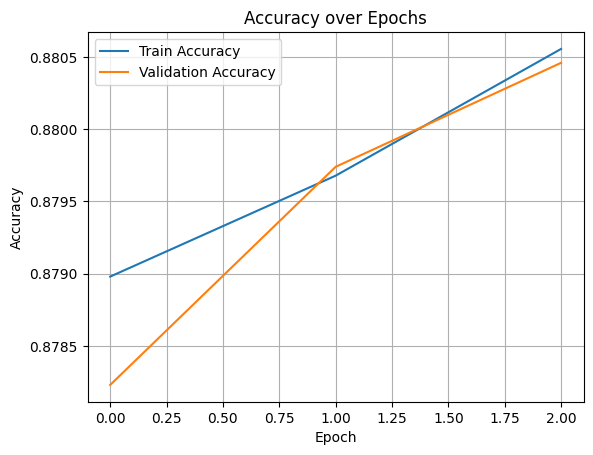

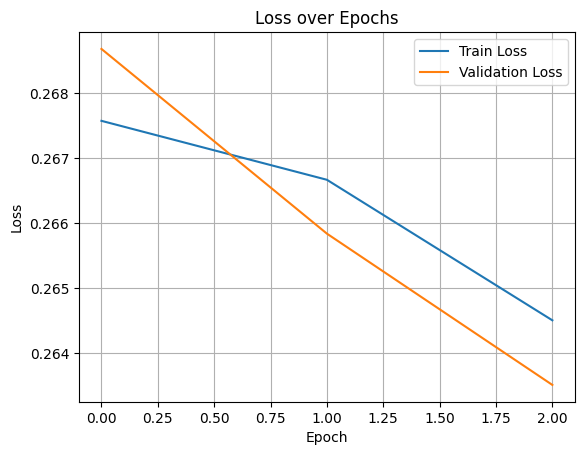

In [ ]:
#  Plot Training History (Accuracy + Loss)
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=800,
    validation_steps=200,
    epochs=3,
    callbacks=[tb]  # Skip early stopping so it finishes all 3 epochs
)


Epoch 1/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 200s 184ms/step - accuracy: 0.8785 - auc_1: 0.9547 - false_negatives_1: 20000.4277 - false_positives_1: 28638.7344 - loss: 0.2682 - precision_1: 0.8629 - recall_1: 0.9001 - val_accuracy: 0.8782 - val_auc_1: 0.9551 - val_false_negatives_1: 11939.0000 - val_false_positives_1: 12415.0000 - val_loss: 0.2687 - val_precision_1: 0.8763 - val_recall_1: 0.8804
Epoch 2/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 143s 179ms/step - accuracy: 0.8791 - auc_1: 0.9549 - false_negatives_1: 19768.1953 - false_positives_1: 28563.2988 - loss: 0.2673 - precision_1: 0.8636 - recall_1: 0.9010 - val_accuracy: 0.8797 - val_auc_1: 0.9558 - val_false_negatives_1: 11339.0000 - val_false_positives_1: 12713.0000 - val_loss: 0.2658 - val_precision_1: 0.8746 - val_recall_1: 0.8867
Epoch 3/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 144s 180ms/step - accuracy: 0.8810 - auc_1: 0.9561 - false_negatives_1: 19602.9746 - false_positives_1: 28165.8008 - loss: 0.2638 - precision_1: 0.8657 - recall_1: 0.9025 - va

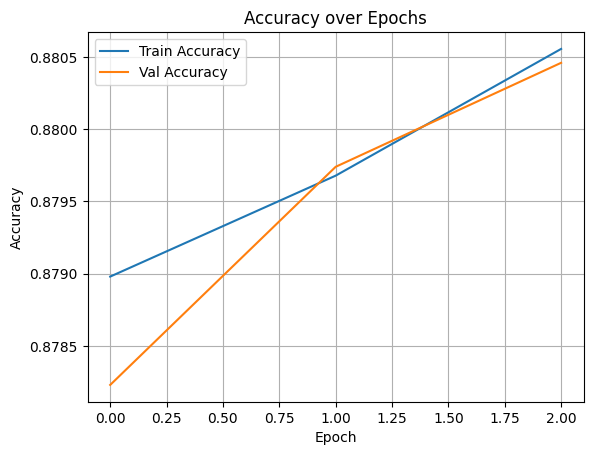

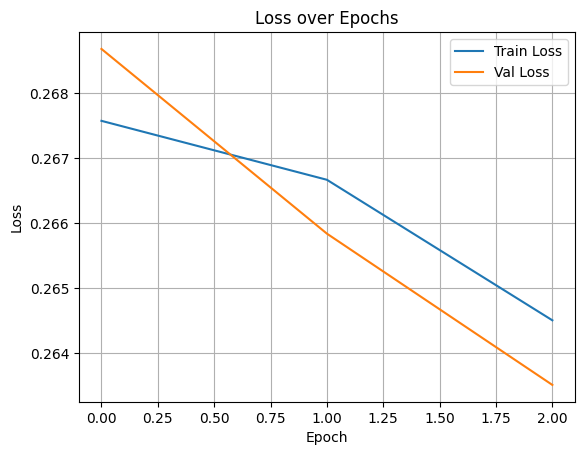

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# evaluate on validaion data:
results = model.evaluate(val_dataset, steps=200)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")


200/200 ━━━━━━━━━━━━━━━━━━━━ 109s 52ms/step - accuracy: 0.8807 - auc_1: 0.9564 - false_negatives_1: 5414.4878 - false_positives_1: 6617.0249 - loss: 0.2631 - precision_1: 0.8721 - recall_1: 0.8924
loss: 0.2625
compile_metrics: 0.8813


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/saved_particle_model')


In [ ]:
#  Export as a .zip file for download or transfer
import shutil
shutil.make_archive('/content/particle_model_export', 'zip', '/content/drive/MyDrive/saved_particle_model')


In [ ]:
#  Generate classification metrics (for the case study)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Get predictions from model on validation data
y_true = []
y_pred = []

for features, labels in val_dataset.take(200):
    preds = model.predict(features)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

# Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

print("\nAUC-ROC:")
print(f"AUC: {roc_auc_score(y_true, y_pred):.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

# Save accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('/content/accuracy_plot.png')
plt.close()

# Save loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('/content/loss_plot.png')
plt.close()
